# Lets just do supervised learning

Since we are looking at pairs with random permuations (from dropout), we can't use CCS. This is because our probabilities do not add to one.

People question if unsupervised learning bings anything to the table anyway, so lets start with supervised...


links:
- [loading](https://github.com/deep-diver/LLM-As-Chatbot/blob/main/models/alpaca.py)
- [dict](https://github.com/deep-diver/LLM-As-Chatbot/blob/c79e855a492a968b54bac223e66dc9db448d6eba/model_cards.json#L143)
- [prompt_format](https://github.com/deep-diver/PingPong/blob/main/src/pingpong/alpaca.py)

In [1]:

import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import random
from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

import pickle
import hashlib
from pathlib import Path

from datasets import load_dataset
import datasets

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoModelForCausalLM, AutoConfig
import transformers
from transformers.models.auto.modeling_auto import AutoModel
from transformers import LogitsProcessorList


import lightning.pytorch as pl
from dataclasses import dataclass

from sklearn.linear_model import LogisticRegression
# from scipy.stats import zscore
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import RobustScaler

from tqdm.auto import tqdm
import gc
import os

from loguru import logger
logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")


transformers.__version__

'4.30.1'

# Load cache data

from notebook 020_ds

In [2]:
from datasets import load_from_disk
f='./.ds/WizardLMWizardCoder_15B_V1.0-None-N_40-ns_3-mc_True-593d1f'
f='./.ds/WizardLMWizardCoder_15B_V1.0-None-N_4000-ns_3-mc_True-a55583_v2'
ds = load_from_disk(f)

In [3]:
batch_size = 32

In [4]:
# # extract data set into N-Dim tensors and 1-d dataframe
# ds_hs = (
#     ds
#     # .map(cast, batched=True, batch_size=batch_size)
#     .with_format("torch", dtype=torch.float16)
# )
# ds_hs[0]

In [5]:
# # TEMP DELETEME cast
# def cast(x):
#     x['hs1'] = torch.tensor(x['hs1']).float()
#     x['hs2'] = torch.tensor(x['hs2']).float()
#     return x

# # extract data set into N-Dim tensors and 1-d dataframe
# ds_hs = (
#     ds
#     .map(cast, batched=True, batch_size=batch_size)
#     .with_format("torch")
# )
# ds_hs[0]
# ds_hs.save_to_disk(f+'_v2')

In [6]:
# ds_hs = (
#     ds.select_columns(['hs1', 'hs2'])
#     .with_format("torch")
# )

# df_infos = pd.DataFrame(ds['info'])
# df_ans = ds.select_columns(['ans1', 'ans2', 'true']).to_pandas()
# df_infos = pd.concat([df_infos, df_ans], axis=1)
# df_infos

## Lightning DataModule

In [7]:
def ds_info2df(ds):
    d = pd.DataFrame(ds['info'])
    for c in ['desired_answer', 'lie', 'true_answer']:
        d[c] = d[c].map(lambda x:x.item())
    return d

class imdbHSDataModule(pl.LightningDataModule):

    def __init__(self,
                 ds,
                 batch_size=32,
                ):
        super().__init__()
        self.save_hyperparameters(ignore=["ds"])
        self.ds = ds

    def setup(self, stage: str):
        h = self.hparams
        
        # extract data set into N-Dim tensors and 1-d dataframe
        self.ds_hs = (
            self.ds.select_columns(['hs1', 'hs2'])
            .with_format("numpy")
        )
        
        df_infos = ds_info2df(self.ds)
        df_ans = self.ds.select_columns(['ans1', 'ans2', 'true']).with_format("numpy").to_pandas()
        self.df_infos = pd.concat([df_infos, df_ans], axis=1)
        self.df_infos['dir_true'] = self.df_infos['ans2'] - self.df_infos['ans1']
        self.df_infos['ans'] = (self.df_infos['ans2'] + self.df_infos['ans1']) / 2
        
        b = len(self.ds_hs)
        self.y = self.df_infos['true_answer'].astype(np.float32).values
        self.hs1 = self.ds_hs['hs1'].reshape((b, -1))#.numpy()
        self.hs2 = self.ds_hs['hs2'].reshape((b, -1))#.numpy()        
        self.ans1 = self.df_infos['ans1'].values
        self.ans2 = self.df_infos['ans2'].values
        
        # # in ELK they cache as a huggingface dataset
        # self.hs1, self.ans1, self.hs2, self.ans2, self.y, self.infos = 

        # let's create a simple 50/50 train split (the data is already randomized)
        n = len(self.y)
        self.val_split = vs = int(n * 0.5)
        self.test_split = ts = int(n * 0.75)
        hs1_train, hs2_train, y_train = self.hs1[:vs], self.hs2[:vs], self.y[:vs]
        hs1_val, hs2_val, y_val = self.hs1[vs:ts], self.hs2[vs:ts], self.y[vs:ts]
        hs1_test, hs2_test, y_test = self.hs1[ts:],self. hs2[ts:], self.y[ts:]

        # for simplicity we can just take the difference between positive and negative hidden states
        # (concatenating also works fine)
        self.x_train = hs1_train - hs2_train
        self.x_val = hs1_val - hs2_val
        self.x_test = hs1_test - hs2_test

        # normalize
        self.scaler = RobustScaler()
        self.scaler.fit(self.x_train)
        self.x_train = self.scaler.transform(self.x_train)
        self.x_val = self.scaler.transform(self.x_val)
        self.x_test = self.scaler.transform(self.x_test)

        self.ds_train = TensorDataset(torch.from_numpy(hs1_train).float(),
                                      torch.from_numpy(hs2_train).float(),
                                      torch.from_numpy(y_train).float())

        self.ds_val = TensorDataset(torch.from_numpy(hs1_val).float(),
                                    torch.from_numpy(hs2_val).float(),
                                    torch.from_numpy(y_val).float())

        self.ds_test = TensorDataset(torch.from_numpy(hs1_test).float(),
                                     torch.from_numpy(hs2_test).float(),
                                     torch.from_numpy(y_test).float())

    def train_dataloader(self):
        return DataLoader(self.ds_train,
                          batch_size=self.hparams.batch_size,
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.hparams.batch_size)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.hparams.batch_size)


In [8]:
# pd.DataFrame(ds.with_format("numpy")['info'])


In [9]:
# test and cache
dm = imdbHSDataModule(ds, batch_size=batch_size)
dm.setup('train')

dl_val = dm.val_dataloader()
dl_train = dm.train_dataloader()
b = next(iter(dl_train))
b

[tensor([[ 2.1326e-01, -3.2684e-02, -4.0253e-02,  ...,  6.3086e-01,
          -3.3594e+00,  1.5766e+01],
         [ 1.7346e-01, -4.2572e-02, -9.0210e-02,  ..., -3.9785e+00,
          -1.6270e+00,  1.3328e+01],
         [ 1.8298e-01, -6.2790e-03, -5.9631e-02,  ..., -6.1523e-01,
           1.4629e+00,  1.2039e+01],
         ...,
         [ 1.1084e-01, -5.6305e-03, -6.7993e-02,  ..., -3.6719e+00,
          -1.8447e+00,  1.2555e+01],
         [ 1.1307e-02, -6.7078e-02, -1.0455e-01,  ..., -3.0723e+00,
           1.4990e+00,  8.6797e+00],
         [ 7.4646e-02, -9.4727e-02, -5.3558e-03,  ..., -2.2324e+00,
          -2.7637e+00,  1.8328e+01]]),
 tensor([[ 1.5747e-01, -7.4844e-03, -7.8857e-02,  ...,  1.4961e+00,
           1.0332e+00,  1.1914e+01],
         [ 1.4172e-01, -6.1523e-02, -4.3152e-02,  ..., -1.5645e+00,
          -2.7734e+00,  1.3078e+01],
         [ 1.1914e-01, -2.0706e-02, -8.9172e-02,  ...,  2.4648e+00,
          -3.6938e-01,  9.6406e+00],
         ...,
         [ 4.0924e-02, -7

In [10]:
hss1 = dm.hs1
hss2 = dm.hs2
ans_1 = dm.ans1
ans_2 = dm.ans2
df_infos = dm.df_infos
df_infos

,desired_answer,input,lie,true_answer,ans1,ans2,true,dir_true,ans
0,True,How can anyone still feed this to children? I ...,True,0,0.519043,0.507324,0,-0.011719,0.513184
1,False,I ordered this movie from Amazon and it was gr...,False,0,0.588379,0.300537,0,-0.287842,0.444336
2,True,This movie has the right pedigree - Coen broth...,True,0,0.201538,0.102234,0,-0.099304,0.151855
3,False,ok so i got the sword and the box it came in w...,False,0,0.366211,0.643555,0,0.277344,0.504883
4,True,I was anticipating the use of wireless headpho...,True,0,0.479980,0.422119,0,-0.057861,0.451172
...,...,...,...,...,...,...,...,...,...
3995,False,"As others have said, the instructions were not...",False,0,0.179932,0.211792,0,0.031860,0.195801
3996,True,This book has great potential but it doesn't l...,True,0,0.032562,0.037292,0,0.004730,0.034912
3997,True,I was intending to use beta sitosterol for hai...,False,1,0.940430,0.942383,1,0.001953,0.941406
3998,False,This is really compact and comes with 3 bags t...,True,1,0.963379,0.941895,1,-0.021484,0.952637


# Model Results

## Task results

E.g. how well does the underlying language model do on the task

In [11]:
print('model acc on sentiment task')
ans = (ans_1 + ans_2) / 2
acc=((ans>0.5)==df_infos['true_answer']).mean()
print(f"acc {acc:2.2f}")

d = df_infos['lie']==True
acc = ((ans[d]>0.5)==df_infos[d]['true_answer']).mean()
print(f"acc when lie=True {acc:2.2f}")

d = df_infos['lie']==False
acc = ((ans[d]>0.5)==df_infos[d]['true_answer']).mean()
print(f"acc when lie=False {acc:2.2f}")
# ((ans_1>0)==df_infos['desired_answer']).mean()

model acc on sentiment task
acc 0.88
acc when lie=True 0.87
acc when lie=False 0.89


# Data prep

We do two inferences on the same inputs. Since we have dropout enabled, even during inference, we get two slightly different hidden states `hs1` and `hs2`, and two slightly different probabilities for our yes and no output tokens `p1` `p2`. We also have the true answer `t`

So there are a few ways we can set up the problem. 

We can vary x:
- `model(hs1)-model(hs2)=y`
- `model(hs1-hs2)==y`

And we can try differen't y's:
- direction with a ranked loss. This could be unsupervised.
- magnitude with a regression loss
- vector (direction and magnitude) with a regression loss

# QC: Linear supervised probes


Let's verify that the model's representations are good

Before trying CCS, let's make sure there exists a direction that classifies examples as true vs false with high accuracy; if supervised logistic regression accuracy is bad, there's no hope of unsupervised CCS doing well.

Note that because logistic regression is supervised we expect it to do better but to have worse generalisation that equivilent unsupervised methods. However in this case CSS is using a deeper model so it is more complicated.


## Try a classification of direction to truth

In [12]:

n = len(df_infos)

# Define X and y
X = hss1-hss2

y = y_dir = df_infos['true_answer'] == (df_infos['dir_true']>0) # direction

# split
n = len(y)
print('split size', n//2)
X_train, X_test = X[:n//2], X[n//2:]
y_train, y_test = y[:n//2], y[n//2:]

# scale
scaler = RobustScaler()
scaler.fit(X_train)
X_train2 = scaler.transform(X_train)
X_test2 = scaler.transform(X_test)

lr = LogisticRegression(class_weight="balanced", penalty="l2", max_iter=380)
lr.fit(X_train2, y_train>0)

split size 2000


LogisticRegression(class_weight='balanced', max_iter=380)

In [13]:
df_infos

,desired_answer,input,lie,true_answer,ans1,ans2,true,dir_true,ans
0,True,How can anyone still feed this to children? I ...,True,0,0.519043,0.507324,0,-0.011719,0.513184
1,False,I ordered this movie from Amazon and it was gr...,False,0,0.588379,0.300537,0,-0.287842,0.444336
2,True,This movie has the right pedigree - Coen broth...,True,0,0.201538,0.102234,0,-0.099304,0.151855
3,False,ok so i got the sword and the box it came in w...,False,0,0.366211,0.643555,0,0.277344,0.504883
4,True,I was anticipating the use of wireless headpho...,True,0,0.479980,0.422119,0,-0.057861,0.451172
...,...,...,...,...,...,...,...,...,...
3995,False,"As others have said, the instructions were not...",False,0,0.179932,0.211792,0,0.031860,0.195801
3996,True,This book has great potential but it doesn't l...,True,0,0.032562,0.037292,0,0.004730,0.034912
3997,True,I was intending to use beta sitosterol for hai...,False,1,0.940430,0.942383,1,0.001953,0.941406
3998,False,This is really compact and comes with 3 bags t...,True,1,0.963379,0.941895,1,-0.021484,0.952637


In [14]:
print("Logistic cls acc: {:2.2%} [TRAIN]".format(lr.score(X_train2, y_train>0)))
print("Logistic cls acc: {:2.2%} [TEST]".format(lr.score(X_test2, y_test>0)))

m = df_infos['lie'][n//2:]
y_test_pred = lr.predict(X_test2)
acc_w_lie = ((y_test_pred[m]>0)==(y_test[m]>0)).mean()
acc_wo_lie = ((y_test_pred[~m]>0)==(y_test[~m]>0)).mean()
print(f'test acc w lie {acc_w_lie:2.2%}')
print(f'test acc wo lie {acc_wo_lie:2.2%}')

Logistic cls acc: 100.00% [TRAIN]
Logistic cls acc: 65.10% [TEST]
test acc w lie 65.70%
test acc wo lie 64.50%


In [15]:
df_info_test = df_infos.iloc[n//2:].copy()
y_pred = lr.predict(X_test2)
df_info_test['inner_truth'] = y_pred
df_info_test

,desired_answer,input,lie,true_answer,ans1,ans2,true,dir_true,ans,inner_truth
2000,True,Candy is simply a tame attempt to stay relevan...,True,0,0.487793,0.701660,0,0.213867,0.594727,False
2001,False,I'm going to start saying that i'm reviewing a...,False,0,0.395508,0.429688,0,0.034180,0.412598,True
2002,True,I am embarrased to admit that I own this book....,True,0,0.742188,0.460449,0,-0.281738,0.601562,True
2003,True,"If you read ""Full Catastrophe Living"" as I did...",False,1,0.965820,0.985840,1,0.020020,0.975586,True
2004,True,My daughter was so excited for this costume. I...,True,0,0.425781,0.153931,0,-0.271973,0.289795,True
...,...,...,...,...,...,...,...,...,...,...
3995,False,"As others have said, the instructions were not...",False,0,0.179932,0.211792,0,0.031860,0.195801,True
3996,True,This book has great potential but it doesn't l...,True,0,0.032562,0.037292,0,0.004730,0.034912,False
3997,True,I was intending to use beta sitosterol for hai...,False,1,0.940430,0.942383,1,0.001953,0.941406,True
3998,False,This is really compact and comes with 3 bags t...,True,1,0.963379,0.941895,1,-0.021484,0.952637,False


### Result, detecting deception?

In [16]:
lie_pred = df_info_test['inner_truth']==df_info_test['true_answer']
lie_true = df_info_test['lie']
acc_lie = accuracy_score(lie_pred, lie_true)
print(f"model can detect lies with acc {acc_lie:2.2%}")
print(f"w lies {sum(lie_true)}/{len(lie_true)} test rows")

model can detect lies with acc 52.00%
w lies 1000/2000 test rows


## Try a regression of the vector (magnitude and direction) vs truth

In [17]:
bool_to_switch = lambda b:b*2-1
true_answer_switch = bool_to_switch(df_infos['true_answer'])
y = y_left_more_true = df_infos['dir_true'] * true_answer_switch


In [18]:
# Try a regression
from sklearn.linear_model import ElasticNet

# Try a classification of direction
n = len(df_infos)

# Define X and y
X = hss1-hss2
y = y_left_more_true * 10

# split
# y = df_infos2['dir2'] * 100
n = len(y)
print('split size', n//2)
X_train, X_test = X[:n//2], X[n//2:]
y_train, y_test = y[:n//2], y[n//2:]

# scale
scaler = RobustScaler()
scaler.fit(X_train)
X_train2 = scaler.transform(X_train)
X_test2 = scaler.transform(X_test)

X_train2 = X_train
X_test2 = X_test2

lr2 = ElasticNet(max_iter=1000,)
lr2.fit(X_train2, y_train)

split size 2000


ElasticNet()

In [19]:
eps = 0.
acc=np.mean((lr2.predict(X_train2)>eps)==(y_train>eps))
print(f'acc from train ElasticNet {acc:2.2f}')
acc=np.mean((lr2.predict(X_test2)>eps)==(y_test>eps))
print(f'acc from test ElasticNet {acc:2.2f}')

acc from train ElasticNet 0.59
acc from test ElasticNet 0.58


Text(0.5, 1.0, 'pred vs true on test')

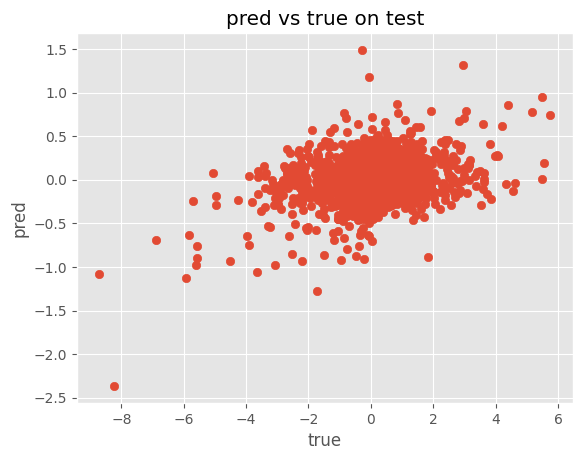

In [20]:
y_test_pred = lr2.predict(X_test)
plt.scatter(y_test, y_test_pred)
plt.xlabel('true')
plt.ylabel('pred')
plt.title('pred vs true on test')

# LightningModel

In [21]:
class MLPProbe(nn.Module):
    def __init__(self, d, depth=0, hs=16, dropout=0):
        super().__init__()

        layers = [
            nn.BatchNorm1d(d),  # this will normalise the inputs
            nn.Linear(d, hs),
            nn.Dropout1d(dropout),
        ]
        for _ in range(depth):
            layers += [
                nn.Linear(hs, hs),
                nn.ReLU(),
                nn.Dropout1d(dropout),
            ]
        layers += [nn.Linear(hs, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [22]:
# logit0 = (torch.rand(5, 4)-0.5)*100
# logit1 = (torch.rand(5, 4)-0.5)*100
# ccs_squared_loss(logit0, logit1)

In [23]:
from pytorch_optimizer import Ranger21
import torchmetrics

    
class CSS(pl.LightningModule):
    def __init__(self, d, total_steps, lr=4e-3, weight_decay=1e-9, dropout=0):
        super().__init__()
        self.probe = MLPProbe(d, depth=1, dropout=dropout)
        self.save_hyperparameters()
        self.auroc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        
    def forward(self, x):
        return self.probe(x)
        
    def _step(self, batch, batch_idx, stage='train'):
        x0, x1, y = batch
        logit0, logit1 = self(x0), self(x1)
        logits = torch.concatenate([logit0, logit1], 1)
        y_pred = F.softmax(logits, -1)
        if stage=='pred':
            return y_pred
        
        loss = F.cross_entropy(logits, y.long())
        self.log(f"{stage}/loss", loss)
        
        self.auroc(y_pred, y.long())
        self.log(f"{stage}/acc_step", self.auroc, on_step=False, on_epoch=True)
        return loss
    
    def on_train_epoch_end(self):
        # log epoch metric
        self.log('train/acc_epoch', self.auroc)
    
    def training_step(self, batch, batch_idx):
        return self._step(batch, batch_idx)
    
    def validation_step(self, batch, batch_idx=0):
        return self._step(batch, batch_idx, stage='val')
    
    def predict_step(self, batch, batch_idx):
        return self._step(batch, batch_idx, stage='pred')

    # def configure_optimizers(self):
    #     optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
    #     lr_scheduler = optim.lr_scheduler.OneCycleLR(
    #         optimizer, self.hparams.lr, total_steps=self.hparams.total_steps
    #     )
        # return [optimizer], [lr_scheduler]
    
    def configure_optimizers(self):
        """use ranger21 from  https://github.com/kozistr/pytorch_optimizer"""
        optimizer = Ranger21(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,       
            num_iterations=self.hparams.total_steps,
        )
        return optimizer
    

# Run

In [24]:
# quiet please
torch.set_float32_matmul_precision('medium')

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*F-score.*")

## Prep dataloader/set

In [25]:
# split
X = hss1-hss2
y = (df_infos['true_answer'] == (df_infos['dir_true']>0)).values # direction
n = len(y)
print('split size', n//2)

neg_hs_train = hss1[:n//2]
pos_hs_train = hss2[:n//2]

neg_hs_val = hss1[n//2:]
pos_hs_val = hss2[n//2:]

y_train, y_val = y[:n//2], y[n//2:]

split size 2000


In [26]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
b = next(iter(dl_train))
# b

In [27]:
# init the model
max_epochs = 50
d = b[0].shape[-1]
net = CSS(d=d, total_steps=max_epochs*len(dl_train), lr=4e-3, weight_decay=1e-1, dropout=0.2)
net

CSS(
  (probe): MLPProbe(
    (net): Sequential(
      (0): BatchNorm1d(116736, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=116736, out_features=16, bias=True)
      (2): Dropout1d(p=0.2, inplace=False)
      (3): Linear(in_features=16, out_features=16, bias=True)
      (4): ReLU()
      (5): Dropout1d(p=0.2, inplace=False)
      (6): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (auroc): MulticlassAccuracy()
)

In [28]:
# with torch.no_grad():
#     b = next(iter(dl_train))
#     b2 = [bb.to(net.device) for bb in b]
#     y = net(b2[0])
# y

In [29]:
# # DEBUG
# trainer = pl.Trainer(fast_dev_run=2)
# trainer.fit(model=net, train_dataloaders=dl_train)

In [42]:
trainer = pl.Trainer(precision="bf16",
                     max_epochs=max_epochs, log_every_n_steps=5)
trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)

/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/lightning/fabric/connector.py:562: UserWarning: bf16 is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
---------------------------------------------
0 | probe | MLPProbe           | 2.1 M 
1 | auroc | MulticlassAccuracy | 0     
---------------------------------------------
2.1 M     Tr

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/ubuntu/mambaforge/envs/dlk2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


# Read hist

In [43]:
# import pytorch_lightning as pl
from lightning.pytorch.loggers.csv_logs import CSVLogger
# from pytorch_lightning.loggers.csv_logs import CSVLogger as CSVLogger2
from pathlib import Path
import pandas as pd

def read_metrics_csv(metrics_file_path):
    df_hist = pd.read_csv(metrics_file_path)
    df_hist["epoch"] = df_hist["epoch"].ffill()
    df_histe = df_hist.set_index("epoch").groupby("epoch").mean()
    return df_histe


def read_hist(trainer: pl.Trainer):

    ts = [t for t in trainer.loggers if isinstance(t, CSVLogger)]
    print(ts)
    try:
        metrics_file_path = Path(ts[0].experiment.metrics_file_path)
        df_histe = read_metrics_csv(metrics_file_path)
        return df_histe
    except Exception as e:
        raise e
        
        
df_hist = read_hist(trainer).ffill().bfill()
df_hist


,train/loss,step,val/loss,val/acc_step,train/acc_step,train/acc_epoch
epoch,,,,,,
0,0.744069,35.857143,0.710270,0.500667,0.0,0.0
1,0.731299,98.133333,0.744243,0.553000,0.0,0.0
2,0.686293,161.000000,0.786604,0.602667,0.0,0.0
3,0.658649,223.266667,0.799057,0.644333,0.0,0.0
4,0.566045,288.000000,0.856216,0.644667,0.0,0.0
5,0.630471,350.857143,0.948994,0.651333,0.0,0.0
6,0.577181,413.133333,1.073932,0.675333,0.0,0.0
7,0.597257,476.000000,1.051913,0.684333,0.0,0.0
8,0.560068,538.266667,1.145453,0.693667,0.0,0.0


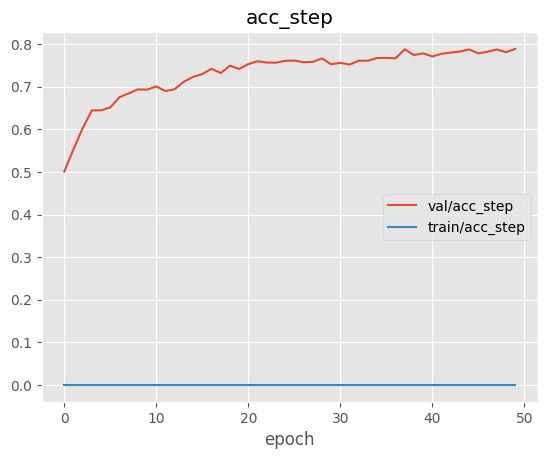

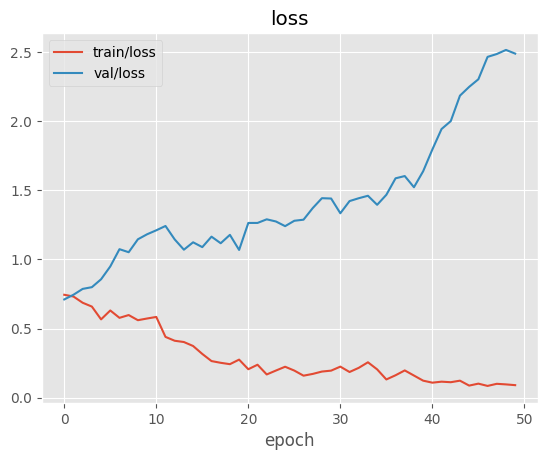

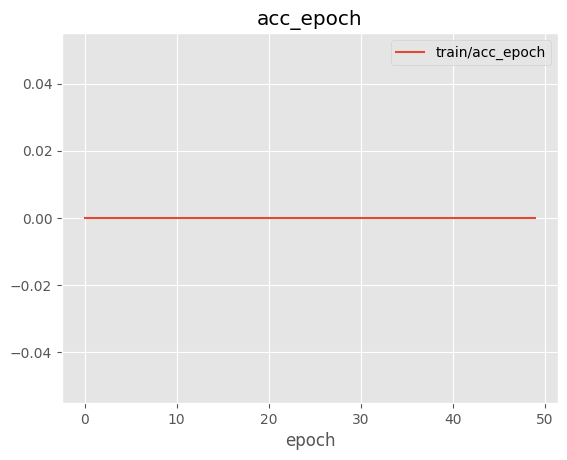

In [44]:
keys = set(s.split('/')[1] for s in df_hist.columns if '/' in s)
for k in keys:    
    df_hist[[c for c in df_hist.columns if c.endswith(k)]].plot(title=k)

In [45]:
# df_hist[['val/acc', 'train/acc']].plot()

# # df_hist[['val/f1', 'train/f1']].plot()

# # df_hist[['val/roc_auc_bc', 'train/roc_auc_bc']].plot()

# # df_hist[['val/roc_auc_mc', 'train/roc_auc_mc']].plot()

# df_hist[['val/loss', 'train/loss']].plot()

## Predict

In [46]:
dl_test = dm.test_dataloader()
y_test_pred = trainer.predict(net, dl_test)
y_test_pred = np.concatenate(y_test_pred)
# y_test_pred

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [47]:
# y_test_pred.shape, df_test.shape
dm.val_split, dm.test_split

(2000, 3000)

In [56]:
df_test = dm.df_infos.iloc[dm.test_split:].copy()
df_test['prob_pred'] = y_test_pred.argmax(-1)
df_test['llm_ans'] = (df_test['ans1']+df_test['ans1'])/2
df_test

,desired_answer,input,lie,true_answer,ans1,ans2,true,dir_true,ans,prob_pred,llm_ans
3000,False,My husband was very pleased with this gift to ...,True,1,0.836914,0.994141,1,0.157227,0.915527,1,0.836914
3001,True,This is simply the best book ever written and ...,False,1,0.714844,0.471924,1,-0.242920,0.593262,0,0.714844
3002,False,I finally found this baster and we love it. It...,True,1,0.966309,0.966309,1,0.000000,0.966309,0,0.966309
3003,True,"thses guys rock, and the vocals are 2nd to..we...",False,1,0.921387,0.884766,1,-0.036621,0.903320,1,0.921387
3004,False,I bought these and wrote a review before - the...,True,1,0.599609,0.395752,1,-0.203857,0.497559,1,0.599609
...,...,...,...,...,...,...,...,...,...,...,...
3995,False,"As others have said, the instructions were not...",False,0,0.179932,0.211792,0,0.031860,0.195801,0,0.179932
3996,True,This book has great potential but it doesn't l...,True,0,0.032562,0.037292,0,0.004730,0.034912,0,0.032562
3997,True,I was intending to use beta sitosterol for hai...,False,1,0.940430,0.942383,1,0.001953,0.941406,1,0.940430
3998,False,This is really compact and comes with 3 bags t...,True,1,0.963379,0.941895,1,-0.021484,0.952637,1,0.963379


In [57]:
y_true = dl_test.dataset.tensors[2].numpy()
assert ((df_test['true_answer'].values>0.5)==(y_true>0.5)).all(), 'check it all lines up'

In [58]:
((df_test['llm_ans']>0.5)==df_test['desired_answer']).mean()

0.516

In [59]:
# this must be wrong
acc_truth = (df_test['prob_pred']==df_test['true_answer']).mean()
print(f"lightning model acc at predicting truth: {acc_truth:2.2%}")

lightning model acc at predicting truth: 50.50%


In [60]:
acc_truth = (df_test['prob_pred']==df_test['desired_answer']).mean()
print(f"lightning model acc at predicting truth: {acc_truth:2.2%}")

lightning model acc at predicting truth: 47.70%


In [61]:
acc_truth = (df_test['prob_pred']==(df_test['llm_ans']>0.5)).mean()
print(f"lightning model acc at predicting truth: {acc_truth:2.2%}")

lightning model acc at predicting truth: 51.30%


OK this doesn't work because for the CSS loss to work, it must add up to 1... ours does not